# Normalize Chromatin and Naked data for ATAC comparison
### Hagai Har-Gil

After some exploration done in the `explore` notebook, this one should be a more succint version of the actual pipeline we wish to preserve.

In [2]:
%load_ext autoreload
%autoreload 2
import pathlib
import copy
from typing import Tuple, List

import seaborn as sns
import numpy as np
import pandas as pd
import skimage.exposure
import matplotlib.pyplot as plt
import scipy.signal
import scipy.fftpack

from ecodam_py.bedgraph import BedGraph
from ecodam_py.eco_atac_normalization import (
    put_on_even_grounds,
    preprocess_bedgraph,
    preprocess_theo,
    convert_to_intervalindex,
    generate_intervals_1kb,
    reindex_data_with_known_intervals,
    reindex_theo_data,
    generate_df_for_theo_correlation_comparison,
    show_ridge_plot,
    subtract_background_with_theo,
    equalize_distribs,
    plot_bg,
    find_closest_diff,
    expand_seeds,
    concat_clusters,
    normalize_df_between_01,
    write_intindex_to_disk,
    get_index_value_for_peaks,
    scatter_peaks_no_peaks,
    separate_top_intensity_values,
    normalize_group_peaks_single_factor,
    normalize_with_theo,
)

In [3]:
eco_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/chromatin_chr15.filter17_60_75.NoBlacklist.NoMask.bedgraph"
)
atac_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/ATAC_rep1to3_Fold_change_over_control.chr15.bedgraph"
)
naked_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/NakedAF647_channel2_chr15_NoMissingChromatinWin.BEDgraph"
)
theo_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/hg38.1kb.windows.InSilico.count.map.sum.bedgraph"
)

In [4]:
beds = preprocess_bedgraph([eco_fname, atac_fname, naked_fname])
beds[1].data.loc[:, "end_locus"] += 100  # ATAC data is built a bit differently

### Theoretical data pre-processing

In parallel we prepare the theoretical data - turn it into an object and reindex it so that it refers to the exact same loci as the naked data, which serves as its reference point. 

There's some averaging going on here, since currently the theoretical data is sampled at (1000, 2000, 3000, ...) bp while the rest of the data is sampled at (500, 1500, 2500, ...) bp. This means that if we want the theoretical data to point at the exact same loci as the naked one, we have to average out every two theoretical values (at least) to find their middle point, which will serve as the new index for the data. This bit will run in `reindex_theo_data`, which is called after the next cell.

In [5]:
theo = preprocess_theo(theo_fname)

### Coercion to the same loci

Next up, we need to do a bit of manipulation to make sure that all values for the different measurements are defined for the exact same loci. The theoretical data will get special treatment later.

The function `put_on_even_grounds` makes sure that the datasets start and end in the same locus, and the `generate_intervals_1kb` function is called on the ATAC data to smooth it out and finally "reindex" it so that it refers to the same loci as the rest of the data. The index here is the locus values at which the measurement was made. Finally, the function `reindex_data_with_known_intervals` does the work of actually changing the indices of the datasets which aren't Eco with chromatin.

In [5]:
beds = put_on_even_grounds(beds)
beds = convert_to_intervalindex(beds)
newint = generate_intervals_1kb(beds[1].data)
eco = beds[0]
atac = beds[1]
naked = beds[2]
atac.data, naked.data, theo.data = reindex_data_with_known_intervals(
    newint, atac, naked, theo, eco.data.index
)
theo.data = reindex_theo_data(naked.data, theo.data)

### Normalization of Naked and Chromatin by ATAC peaks

We'll try a new method for normalization. Consider that the open parts of the genome, as detected by HMMRATAC, should have bright fluorescence, and that brightness value should be approximately equal for all open parts of the genome. Here's we'll try to find a normalization factor that turns all of the peaks of the Naked and Chromatin tracks to an equal hight, and then we could subtract the two tracks, after a normalization step or two.

This will result in a third track that should be a mirror image of the original ATAC track, since the open areas will be very low (high Naked - high chromatin) while the closed areas should be quite bright (high naked - low chromatin).

In [6]:
peak_calling_atac = pd.read_csv(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/NA_summits.bed",
    sep="\t",
    names=["chr", "start", "end", "peaknum", "height"],
)

This notebook currently only deals with chromosome 15, so first we filter the relevant peaks (a value of `50` was chosen, it's considered pretty standard) and then connect them to our existing 1 kb sampled index:

In [7]:
peaks_chr15 = peak_calling_atac.query('chr == "chr15" & height > 50')
peaks_chr15 = get_index_value_for_peaks(peaks_chr15, eco.data)
non_peaks_chr15 = np.setdiff1d(np.arange(len(eco.data)), peaks_chr15)

Let's first observe how does the Naked and Chromatin peak data looks like - i.e. the values of one of these tracks at the HMMRATAC-defined indices.

<AxesSubplot:xlabel='Chromatin', ylabel='Naked'>

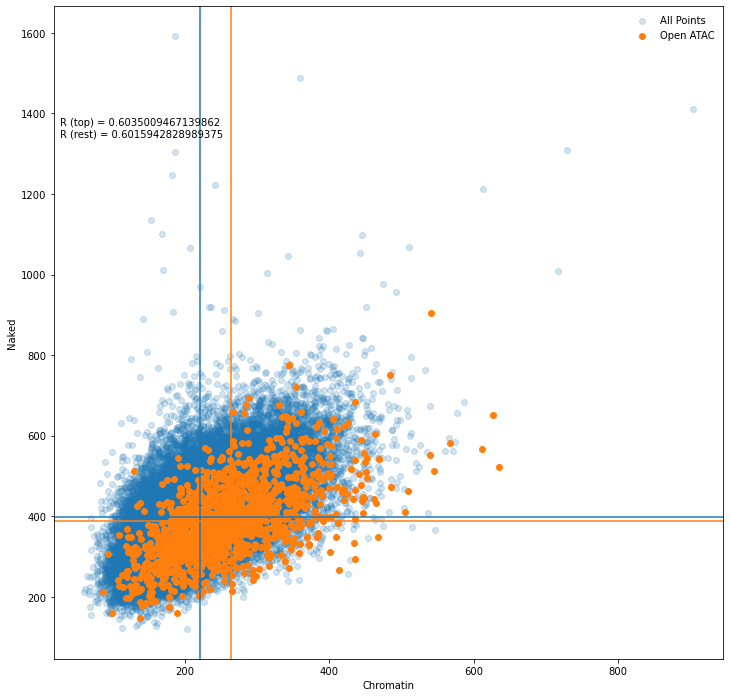

In [8]:
top_chrom, top_naked, non_top_chrom, non_top_naked = separate_top_intensity_values(eco.data, naked.data, peaks_chr15, non_peaks_chr15)
scatter_peaks_no_peaks(top_chrom, top_naked, non_top_chrom, non_top_naked)

The differences are very small - the peak-based Chromatin data is just slightly higher than the rest of the data. This is, again, a testament to the low SNR we're working with.

Befor moving on, let's look at the data in one more way:


In [9]:
all_chrom = pd.concat([non_top_chrom, top_chrom], keys=['all', 'top'])
all_naked = pd.concat([non_top_naked, top_naked], keys=['all', 'top'])
chrom_and_naked = pd.concat([all_chrom, all_naked], keys=['chrom', 'naked'])
chrom_and_naked.index.rename(['source', 'measurement', 'locus'], inplace=True)

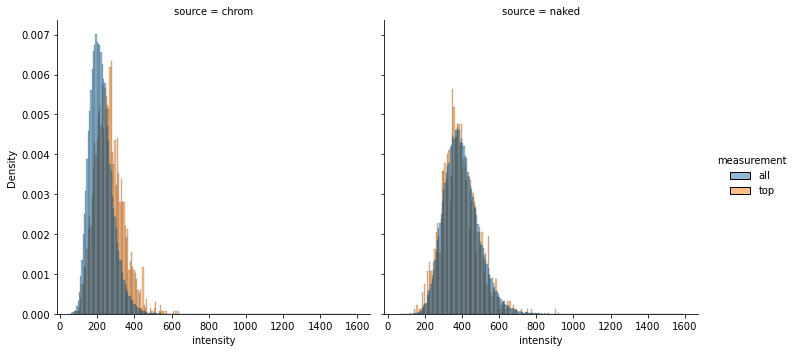

In [10]:
sns.displot(data=chrom_and_naked.to_frame(), x='intensity', hue='measurement', common_norm=False, stat='density', col='source')

We'll divide the whole chromosome into groups - each time we'll only take 100 (or so) peaks, bundle them together and do the normalization and analysis steps inside that group.

In [11]:
# Divide the peaks into groups
groupnum = 20  # nearly even groups
segments = np.linspace(0, len(peaks_chr15), num=groupnum, dtype=np.int64, endpoint=True)[1:-1]
# Define the limits of each group using peak index
peak_segments = peaks_chr15[segments]
peak_groups = np.split(peaks_chr15, segments)
# Split up data at these intervals
naked_groups = np.split(naked.data.loc[:, "intensity"], peak_segments)
chrom_groups = np.split(eco.data.loc[:, "intensity"], peak_segments)
theo_groups = np.split(theo.data.loc[:, "intensity"], peak_segments)
print(f"Generated {len(segments)} groups!")
# Change peak indices to relative per group
peak_segments = np.concatenate([[0], peak_segments])
peak_groups_relative = [
    group - starting for group, starting in zip(peak_groups, peak_segments)
]
peak_segments = np.concatenate([peak_segments, [len(naked.data)]])

Generated 18 groups!


We'll also divide the non-peak indices into the same groups - they just need a different treatment:

In [12]:
non_peak_groups = []
non_peak_groups_relative = []
for idx, start in enumerate(peak_segments[:-1]):
    end = peak_segments[idx + 1]
    mask = (non_peaks_chr15 >= start) & (non_peaks_chr15 < end)
    non_peak_groups.append(non_peaks_chr15[mask])
    non_peak_groups_relative.append(non_peaks_chr15[mask] - start)

For each of these groups we wish to draw the same scatterplot as we did before for the entire chromosome, since it might be of interest to find areas that are more or less affected by the peaks.

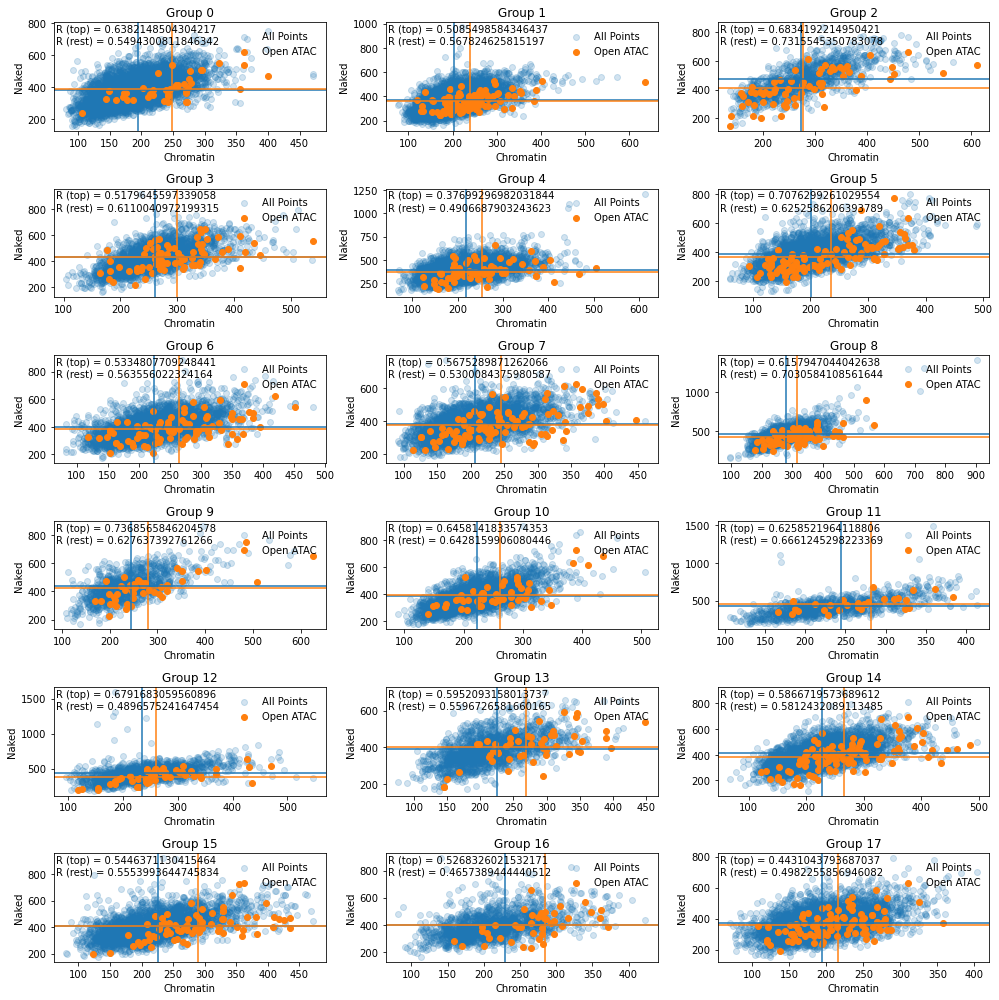

In [13]:
fig_groups, ax_groups = plt.subplots(6, 3, figsize=(14, 14))
for idx, (ax_grp, peaks, non_peaks, chrom, nak) in enumerate(zip(ax_groups.flat, peak_groups_relative, non_peak_groups_relative, chrom_groups, naked_groups)):
    ax = scatter_peaks_no_peaks(chrom.iloc[peaks], nak.iloc[peaks], chrom.iloc[non_peaks], nak.iloc[non_peaks], ax_grp)
    ax.set_title(f"Group {idx}")
ax.figure.tight_layout()
    

The main takeaways are that the chromatin data seems to be more sensitive to the peaks than the naked data. This is expected since the naked data is always open. We also see that some groups have relatively lower Chromatin SNR than other, or in other words the data in these groups doesn't reflect well the openness of the chromosome as the ATAC data suggests.

Now let's go over group-by-group and normalize the peaks between the chromatin and naked data. This normalization step is composed of two steps:

1. Match the peak heights of the naked and chromatin data. This step makes sure that the group's peaks are more-or-less identical in their average height. This is important if we wish to subtract the two tracks.
2. Remove the background noise from the tracks. The background levels of the two tracks a bit different, which might hurt the subtraction step.

After normalization we'll take two actions:

1. Generate a subtraction group after these previously-described steps.
2. Normlize the chromatin data from the naked, by equalizing the naked data's height and then applying that same filter to the chromatin data.

Regardless of the action used, we'll remove areas with low theoretical values since they're less credible. 

In [14]:
chrom_norm_groups, naked_norm_groups, chrom_normed_by_naked_groups = [], [], []
subtraction = pd.DataFrame(columns=['intensity'], index=eco.data.index)
for peaks, nakedgroup, chromgroup, theogroup in zip(peak_groups_relative, naked_groups, chrom_groups, theo_groups):
    naked_norm, norm = normalize_group_peaks_single_factor(peaks, nakedgroup)
    chrom_norm, _ = normalize_group_peaks_single_factor(peaks, chromgroup, norm_to=norm)
    naked_norm = subtract_background_with_theo(naked_norm, theogroup)
    chrom_norm = subtract_background_with_theo(chrom_norm, theogroup)
    subtraction.loc[chrom_norm.index, 'intensity'] = (naked_norm - chrom_norm)
    chrom_norm_groups.append(chrom_norm.dropna())
    naked_norm_groups.append(naked_norm.dropna())
subtraction = subtraction.dropna()
chrom_norm_all = pd.concat(chrom_norm_groups)
naked_norm_all = pd.concat(naked_norm_groups)

In [17]:
new_foldername = eco_fname.parent / 'data_after_group_norm'
new_foldername.mkdir(exist_ok=True)
write_intindex_to_disk(chrom_norm_all, new_foldername / "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_after_group_normalization.bedgraph")
write_intindex_to_disk(naked_norm_all, new_foldername / "NakedAF647_channel2_chr15_NoMissingChromatinWin_after_group_normalization.bedgraph")
write_intindex_to_disk(subtraction, new_foldername / "naked_minus_chromatin.bedgraph")

We'll plot the correlation between the theoretical data and the other datasets we currently have - subtracted track and the chromatin and naked tracks. Then we'll correct for the theoretical data and see how it looks like again.

In [1]:
theo_no_zero = theo.data.dropna()
theo_no_zero = theo_no_zero.loc[theo_no_zero.intensity != 0, "intensity"].to_frame()
theo_no_zero = theo_no_zero.reindex(subtraction.index)
theo_no_zero.loc[:, "subtraction"] = subtraction.intensity
theo_no_zero.loc[:, "chromatin"] = chrom_norm_all
theo_no_zero.loc[:, "naked"] = naked_norm_all
theo_no_zero = theo_no_zero.rename({"intensity": "theo_value"}, axis=1)

NameError: name 'theo' is not defined

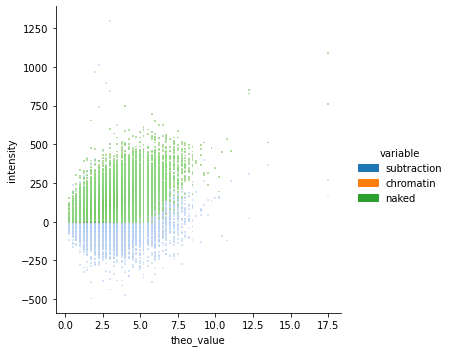

In [21]:
sns.displot(
    data=theo_no_zero.melt(
        id_vars=['theo_value'], 
        value_name='intensity',
    ), 
    x='theo_value', 
    y='intensity', 
    hue='variable',
    alpha=0.5,
)

In [22]:
subtraction.loc[:, "intensity"] = normalize_with_theo(subtraction.intensity, theo.data)
chrom_norm_theo = normalize_with_theo(chrom_norm_all, theo.data)
naked_norm_theo = normalize_with_theo(naked_norm_all, theo.data)

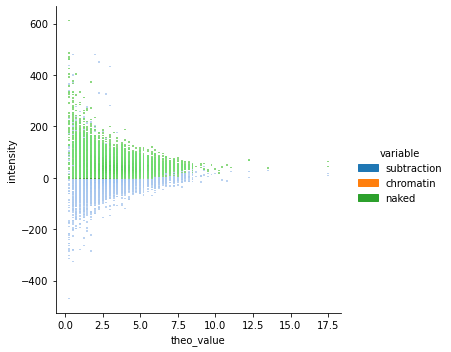

In [30]:
theo_no_zero_normed = theo_no_zero.copy()
theo_no_zero_normed.loc[:, "subtraction"] = subtraction.intensity
theo_no_zero_normed.loc[:, "chromatin"] = chrom_norm_theo
theo_no_zero_normed.loc[:, "naked"] = naked_norm_theo
sns.displot(
    data=theo_no_zero_normed.melt(
        id_vars=['theo_value'], 
        value_name='intensity',
    ), 
    x='theo_value', 
    y='intensity', 
    hue='variable',
    alpha=0.8,
)

In [25]:
new_foldername = eco_fname.parent / 'data_after_theo_norm'
new_foldername.mkdir(exist_ok=True)
write_intindex_to_disk(chrom_norm_all, new_foldername / "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_after_theo_normalization.bedgraph")
write_intindex_to_disk(naked_norm_all, new_foldername / "NakedAF647_channel2_chr15_NoMissingChromatinWin_after_theo_normalization.bedgraph")
write_intindex_to_disk(subtraction, new_foldername / "naked_minus_chromatin_after_theo_norm.bedgraph")

In [27]:
chrom_norm_all.mean(), naked_norm_all.mean()

(136.5468438854646, 136.5468438854646)